In [22]:
import pandas as pd
from sklearn.model_selection import GroupKFold, cross_validate, StratifiedGroupKFold
from statsmodels.stats.stattools import durbin_watson
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# Load the data
data = pd.read_csv('HR_data.csv')

# Drop rows with missing values (if any)
data = data.dropna()

# Binarize the frustration levels based on the median
median_frustration = 4
data['Frustrated'] = (data['Frustrated'] >= median_frustration).astype(int)

# Define features and target variable
features = ['HR_Median', 'HR_Mean', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
target = 'Frustrated'
X = data[features]
y = data[target]
groups = data['Individual']

# Function to print class balances using custom shuffled GroupKFold
def print_class_balances(splits, X, y, groups):
    total_frustrated = y.value_counts().get(1, 0)
    
    for fold, (_, test_idx) in enumerate(splits):
        y_test = y.iloc[test_idx]
        test_class_counts = y_test.value_counts()
        test_frustrated_count = test_class_counts.get(1, 0)
        test_percentage_frustrated = (test_frustrated_count / total_frustrated) * 100
        print(f"Fold {fold+1}: Test % Frustrated (compared to total): {test_percentage_frustrated:.2f}%")

# Custom function to shuffle data and then apply GroupKFold
def shuffled_group_k_fold(X, y, groups, n_splits=12, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    # Shuffle the data
    X_shuffled, y_shuffled, groups_shuffled = shuffle(X, y, groups, random_state=random_state)
    gkf = GroupKFold(n_splits=n_splits)
    return list(gkf.split(X_shuffled, y_shuffled, groups_shuffled))

# Apply the custom shuffled GroupKFold
splits = shuffled_group_k_fold(X, y, groups, n_splits=12, random_state=41)
sgkf = StratifiedGroupKFold(n_splits=9, shuffle=True)

# Print class balances in each fold
print_class_balances(splits, X, y, groups)

# Define models in a dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'Baseline': DummyClassifier(strategy="most_frequent")
}

# Define scoring metrics
scoring = ['accuracy']
anova_metrics = ['accuracy']

# Store cross-validated scores for each model
cv_results = {}
for model_name, model in models.items():
    cv_results[model_name] = cross_validate(model, X, y, groups=groups, cv=splits, scoring=scoring, return_train_score=True)

# Extract accuracy scores for each model
accuracy_scores = {model_name: cv_results[model_name]['test_accuracy'] for model_name in models}

for model_name, scores in accuracy_scores.items():
    mean_accuracy = np.mean(scores)
    print(f'Mean accuracy for {model_name}: {mean_accuracy:.4f}')

# Perform ANOVA test on accuracy scores
anova_result = stats.f_oneway(accuracy_scores['RandomForest'], accuracy_scores['LogisticRegression'], accuracy_scores['Baseline'])
print(f'ANOVA result (p-value): {anova_result.pvalue:.4f} -> {"No significant difference in accuracies" if anova_result.pvalue > 0.05 else "Significant difference in accuracies"}')

# Check for normality using Shapiro-Wilk test
shapiro_results = {}
for model_name, scores in accuracy_scores.items():
    shapiro_result = stats.shapiro(scores)
    shapiro_results[model_name] = shapiro_result.pvalue
    print(f'Shapiro-Wilk test on {model_name}: p-value: {shapiro_result.pvalue:.4f} -> {"Normally distributed" if shapiro_result.pvalue > 0.05 else "NOT normally distributed"}')

# Check for homogeneity of variance using Levene's test
levene_result = stats.levene(accuracy_scores['RandomForest'], accuracy_scores['LogisticRegression'], accuracy_scores['Baseline'])
print(f'Levene\'s test: p-value: {levene_result.pvalue:.4f} -> {"Variances ARE homogeneous" if levene_result.pvalue > 0.05 else "Variances are NOT homogeneous"}')

# Calculate residuals
residuals = {model_name: scores - np.mean(scores) for model_name, scores in accuracy_scores.items()}
# Check if residuals have mean 0
for model_name, res in residuals.items():
    mean_residual = np.mean(res)
    print(f'Mean of residuals for {model_name}: {mean_residual:.4e}')

dw = {}
# Check for independence of residuals using Durbin-Watson test
for model_name, res in residuals.items():
    dw_statistic = durbin_watson(res)
    dw[model_name] = dw_statistic
    print(f'Durbin-Watson statistic for {model_name}: {dw_statistic:.4f} -> {"Residuals are independent" if 1.5 < dw_statistic < 2.5 else "Residuals are NOT independent"}')

Fold 1: Test % Frustrated (compared to total): 6.38%
Fold 2: Test % Frustrated (compared to total): 21.28%
Fold 3: Test % Frustrated (compared to total): 8.51%
Fold 4: Test % Frustrated (compared to total): 2.13%
Fold 5: Test % Frustrated (compared to total): 6.38%
Fold 6: Test % Frustrated (compared to total): 12.77%
Fold 7: Test % Frustrated (compared to total): 12.77%
Fold 8: Test % Frustrated (compared to total): 4.26%
Fold 9: Test % Frustrated (compared to total): 2.13%
Fold 10: Test % Frustrated (compared to total): 6.38%
Fold 11: Test % Frustrated (compared to total): 12.77%
Fold 12: Test % Frustrated (compared to total): 4.26%
Mean accuracy for RandomForest: 0.6771
Mean accuracy for LogisticRegression: 0.6944
Mean accuracy for Baseline: 0.7188
ANOVA result (p-value): 0.8128 -> No significant difference in accuracies
Shapiro-Wilk test on RandomForest: p-value: 0.5500 -> Normally distributed
Shapiro-Wilk test on LogisticRegression: p-value: 0.0974 -> Normally distributed
Shapiro-

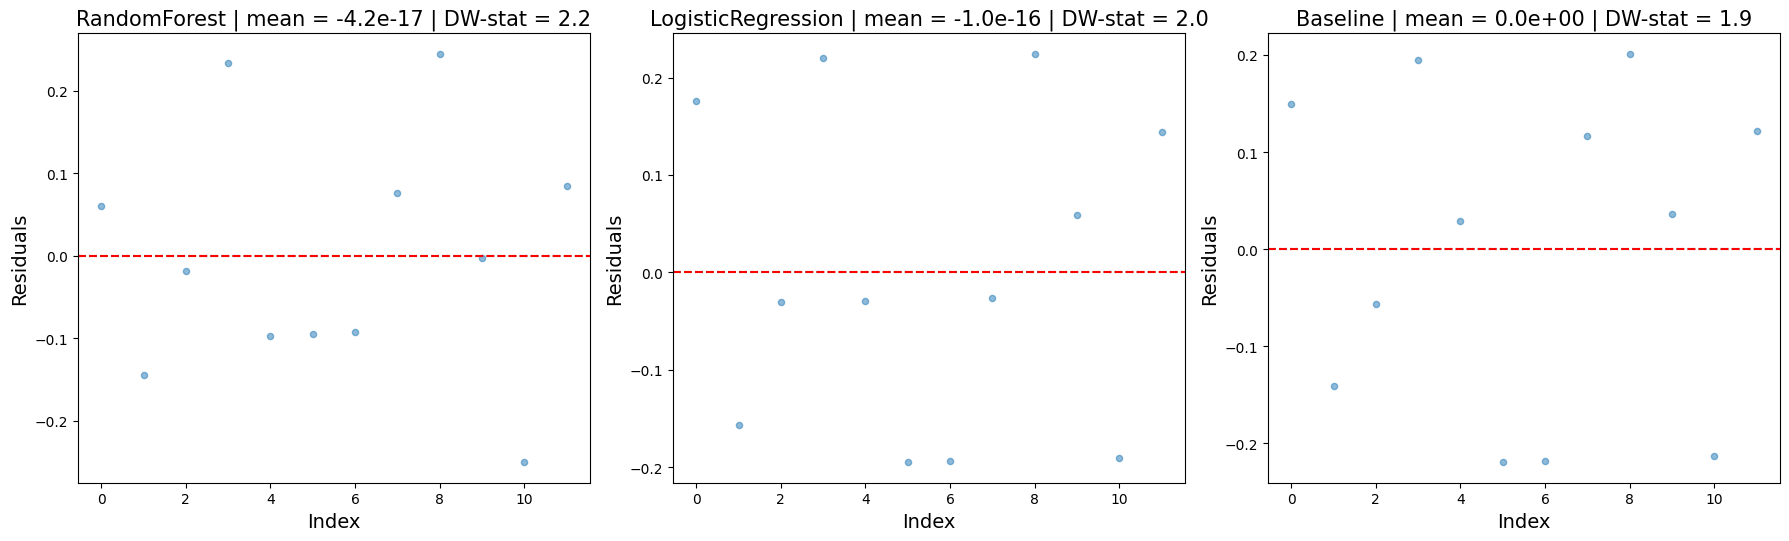

In [23]:
# Plot residuals for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (model_name, res) in zip(axes, residuals.items()):
    sns.residplot(x=np.arange(len(res)), y=res, ax=ax, scatter_kws={'s': 20, 'alpha': 0.5})
    ax.set_title(f'{model_name} | mean = {np.mean(res):.1e} | DW-stat = {round(dw[model_name],1)}', fontsize=15)
    ax.set_xlabel('Index', fontsize=14)
    ax.set_ylabel('Residuals', fontsize=14)
    ax.axhline(0, color='red', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



RandomForest - Robustness (Variance in Accuracy): 0.0203
RandomForest - Generalization (Train Mean Accuracy): 0.9946, (Test Mean Accuracy): 0.6771
LogisticRegression - Robustness (Variance in Accuracy): 0.0244
LogisticRegression - Generalization (Train Mean Accuracy): 0.7051, (Test Mean Accuracy): 0.6944
Baseline - Robustness (Variance in Accuracy): 0.0246
Baseline - Generalization (Train Mean Accuracy): 0.7202, (Test Mean Accuracy): 0.7188
RandomForest - Consistency (Std Dev in Accuracy): 0.1424
LogisticRegression - Consistency (Std Dev in Accuracy): 0.1562
Baseline - Consistency (Std Dev in Accuracy): 0.1569


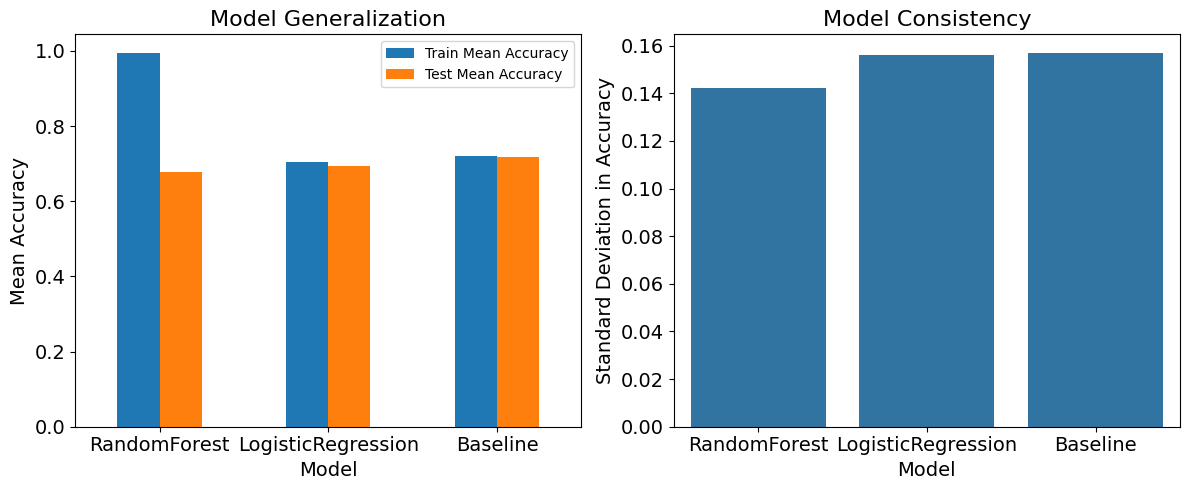

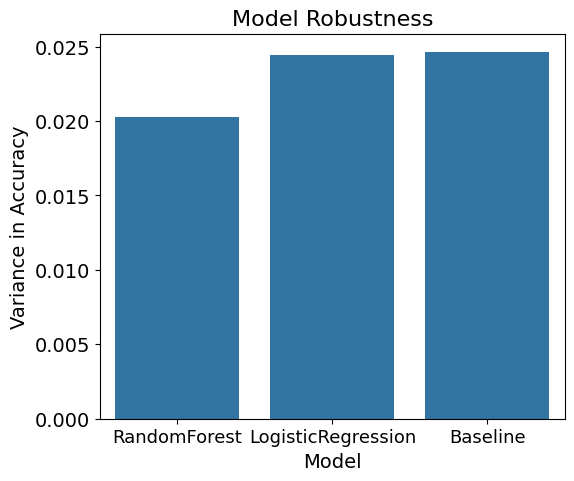

In [24]:
# Function to calculate robustness by checking variance in scores
def calculate_robustness(scores):
    return np.var(scores)

# Function to check generalization by comparing training and test scores
def calculate_generalization(cv_results, model_name):
    train_scores = cv_results[model_name]['train_accuracy']
    test_scores = cv_results[model_name]['test_accuracy']
    return np.mean(train_scores), np.mean(test_scores)

# Collecting robustness and generalization metrics
robustness = {model_name: calculate_robustness(scores) for model_name, scores in accuracy_scores.items()}
generalization = {model_name: calculate_generalization(cv_results, model_name) for model_name in models}

# Print robustness and generalization metrics
for model_name in models:
    train_mean, test_mean = generalization[model_name]
    print(f"{model_name} - Robustness (Variance in Accuracy): {robustness[model_name]:.4f}")
    print(f"{model_name} - Generalization (Train Mean Accuracy): {train_mean:.4f}, (Test Mean Accuracy): {test_mean:.4f}")

# Consistency check using standard deviation
consistency = {model_name: np.std(scores) for model_name, scores in accuracy_scores.items()}

# Print consistency metrics
for model_name, std_dev in consistency.items():
    print(f"{model_name} - Consistency (Std Dev in Accuracy): {std_dev:.4f}")

# Plot robustness, generalization, and consistency for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Generalization plot
generalization_data = [(model_name, *generalization[model_name]) for model_name in models]
generalization_df = pd.DataFrame(generalization_data, columns=['Model', 'Train Mean Accuracy', 'Test Mean Accuracy'])
generalization_df.set_index('Model').plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Generalization', fontsize=16)
axes[0].set_ylabel('Mean Accuracy', fontsize=14)
axes[0].set_xlabel('Model', fontsize=14)
axes[0].tick_params(axis='x', rotation=0, labelsize=14)  # Rotate x-tick labels and set font size
axes[0].tick_params(axis='y', labelsize=14)  # Set y-tick labels font size

# Consistency plot
sns.barplot(x=list(consistency.keys()), y=list(consistency.values()), ax=axes[1])
axes[1].set_title('Model Consistency', fontsize=16)
axes[1].set_ylabel('Standard Deviation in Accuracy', fontsize=14)
axes[1].set_xlabel('Model', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)  # Set x-tick labels font size
axes[1].tick_params(axis='y', labelsize=14)  # Set y-tick labels font size

plt.tight_layout()
plt.show()

# Plot robustness
plt.figure(figsize=(6, 5))
sns.barplot(x=list(robustness.keys()), y=list(robustness.values()))
plt.title('Model Robustness', fontsize=16)
plt.ylabel('Variance in Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.tick_params(axis='x', labelsize=13)  # Set x-tick labels font size
plt.tick_params(axis='y', labelsize=14)  # Set y-tick labels font size
plt.show()


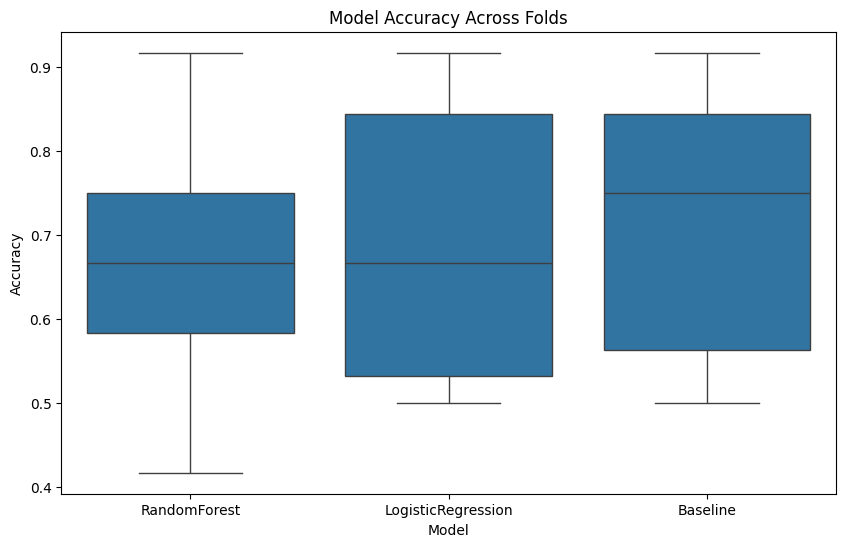

In [25]:
# Prepare data for plotting
accuracy_data = []
for model_name, scores in accuracy_scores.items():
    for fold_idx, score in enumerate(scores):
        accuracy_data.append({
            'Model': model_name,
            'Fold': fold_idx + 1,
            'Accuracy': score
        })

# Convert to DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the box plot
sns.boxplot(x='Model', y='Accuracy', data=accuracy_df)
# sns.stripplot(x='Model', y='Accuracy', data=accuracy_df, color='red', jitter=True, size=5, alpha=0.6)

# Add title and labels
plt.title('Model Accuracy Across Folds')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()


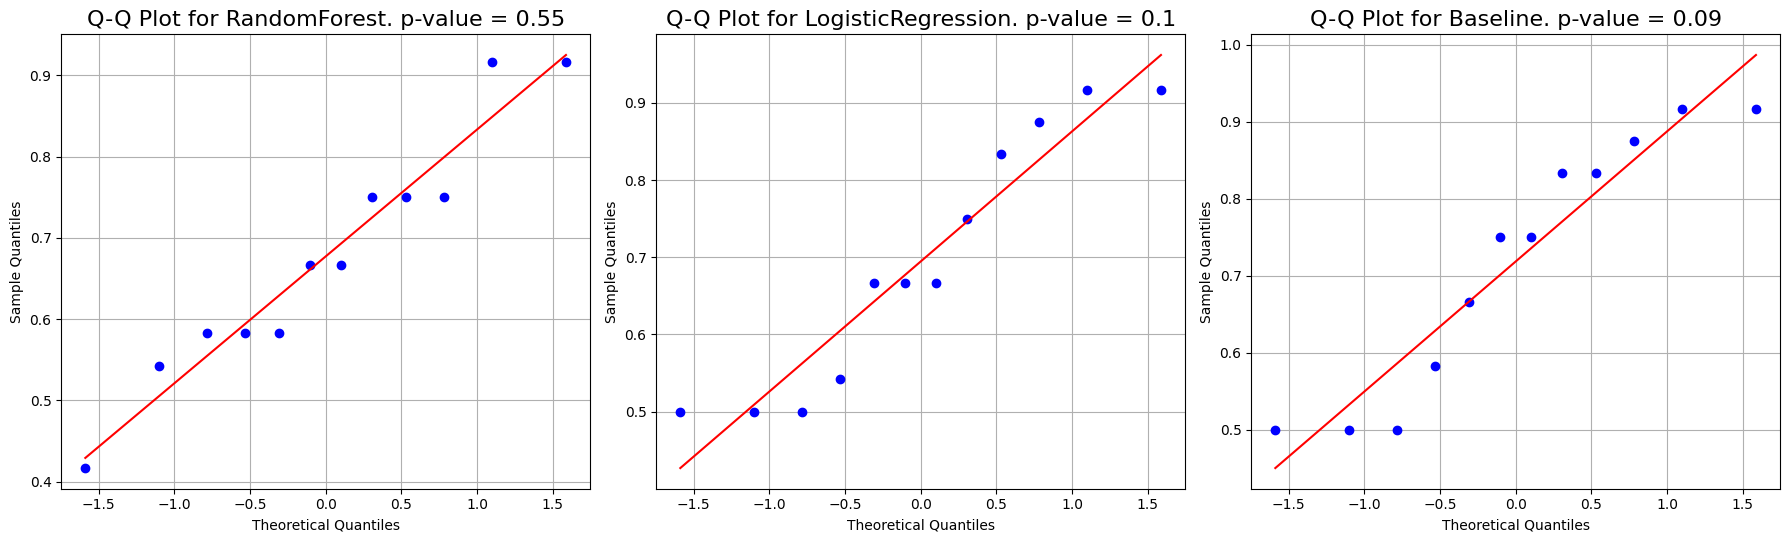

In [26]:
# Function to create Q-Q plot on a specified axis
def qq_plot(data, title, ax, pvalue):
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot for {title}. p-value = {round(pvalue,2)}', fontsize=16)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.grid(True)

# Create Q-Q plots for accuracy scores
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (model_name, scores) in zip(axs, accuracy_scores.items()):
    qq_plot(scores, model_name, ax, shapiro_results[model_name])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# # Create Q-Q plots for residuals
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle('Q-Q Plots for Residuals')

# for ax, (model_name, res) in zip(axs, residuals.items()):
#     qq_plot(res, model_name, ax, shapiro_results[model_name])

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


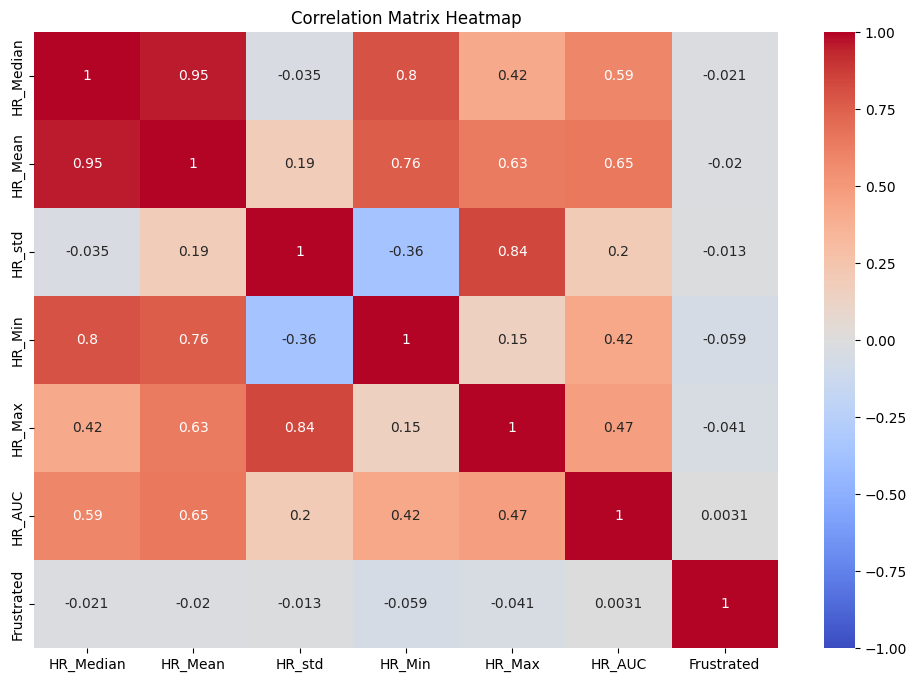

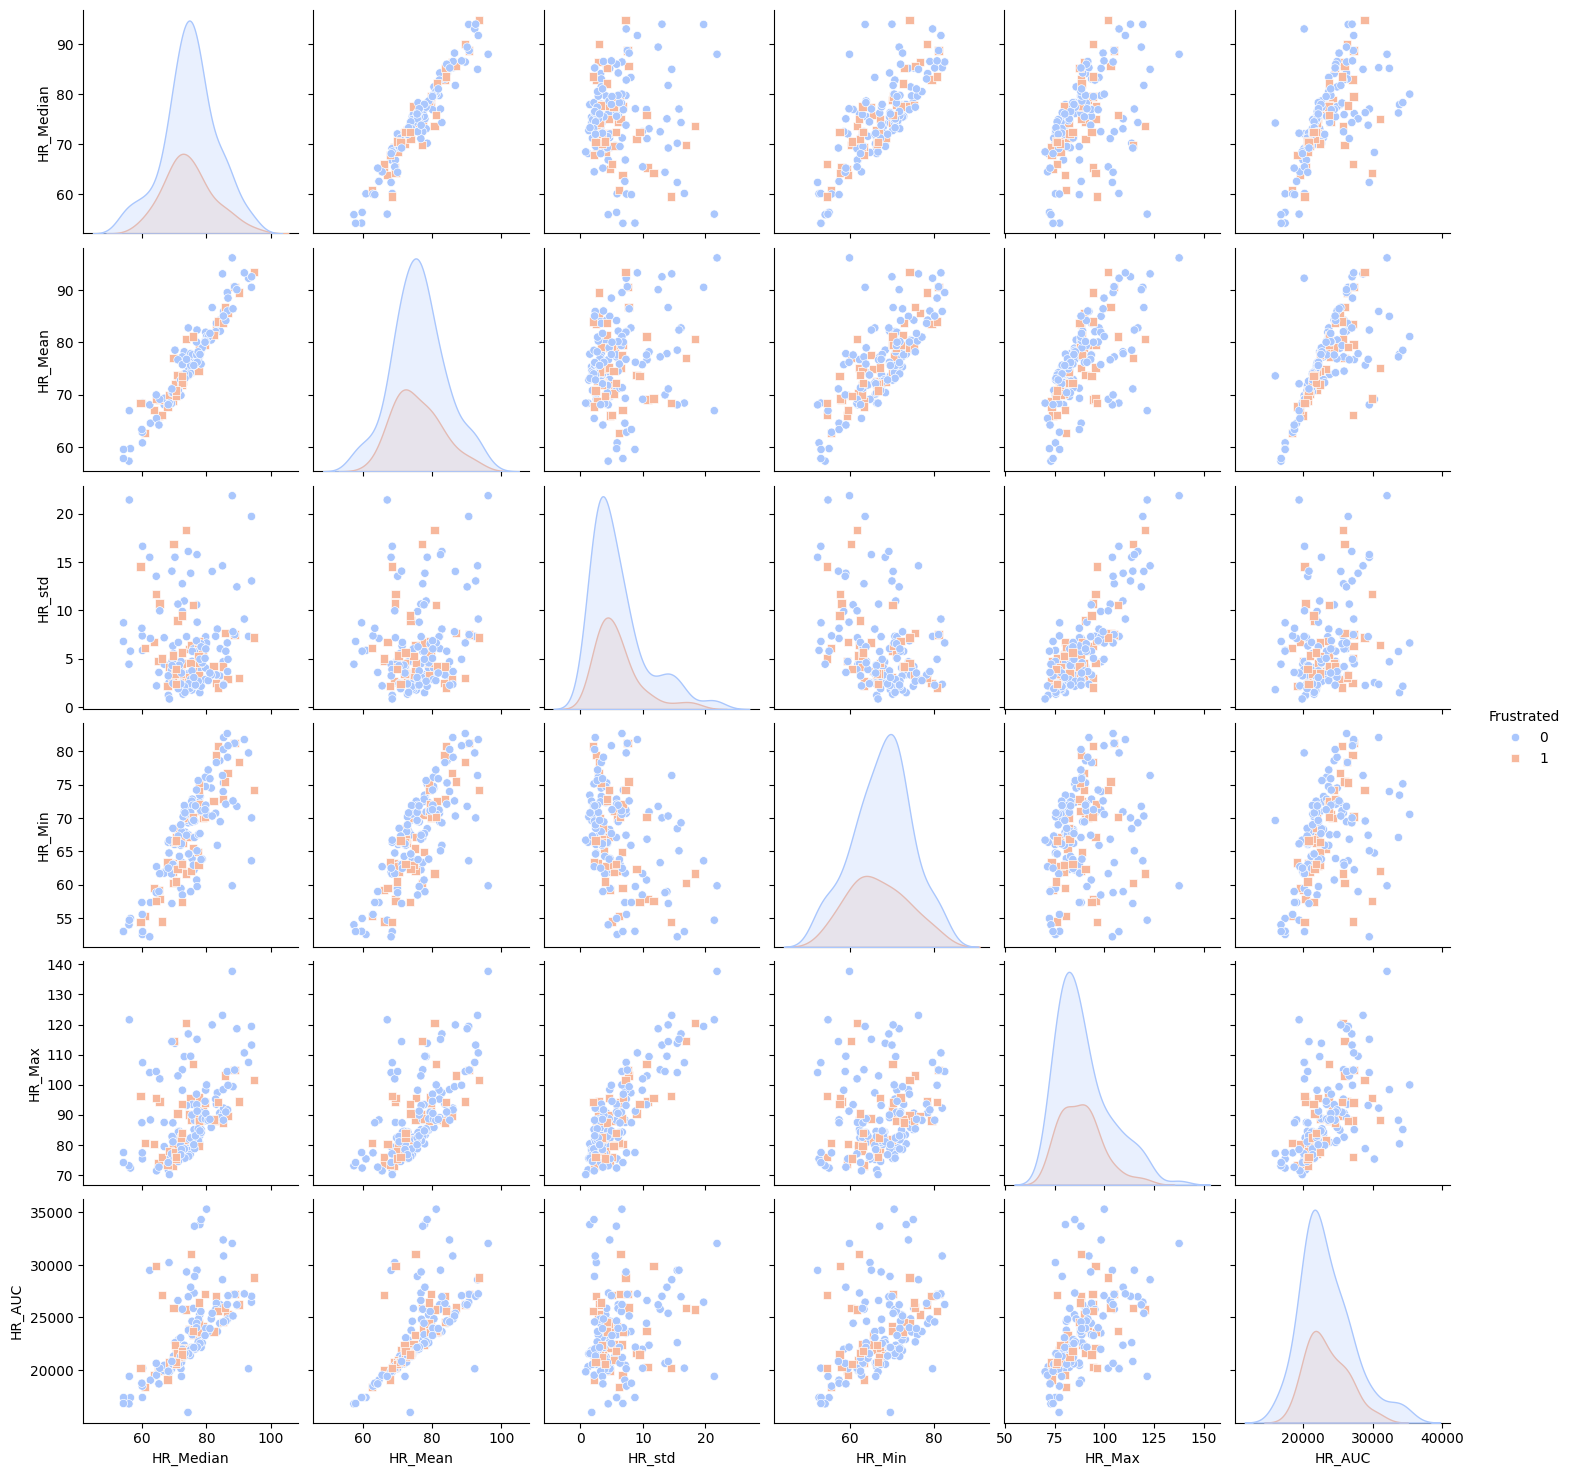

In [27]:
# Combine features and target into a single DataFrame for correlation
data_corr = pd.concat([X, y], axis=1)

# Calculate the correlation matrix
corr = data_corr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Pairplot for detailed relationships
sns.pairplot(data_corr, hue=target, diag_kind='kde', markers=["o", "s"], palette='coolwarm')
plt.show()
